# Chap 03.04. VAE with Face


----

Conda env : [cv_playgrounds](../../../README.md#setup-a-conda-environment)

----


- Ref : https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/tree/main/notebooks/03_vae/03_vae_faces
- Data : 
    - https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data 
    - https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ



## 0. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

In [2]:
### 0.1 Utils

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


## 1. Parameters

In [3]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 30
BETA = 2000
LOAD_MODEL = False

## 2. Prepare Data

Found 202599 files belonging to 1 classes.


2025-05-06 15:02:31.544331: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-06 15:02:31.544374: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-06 15:02:31.544384: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-06 15:02:31.544439: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-06 15:02:31.544468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


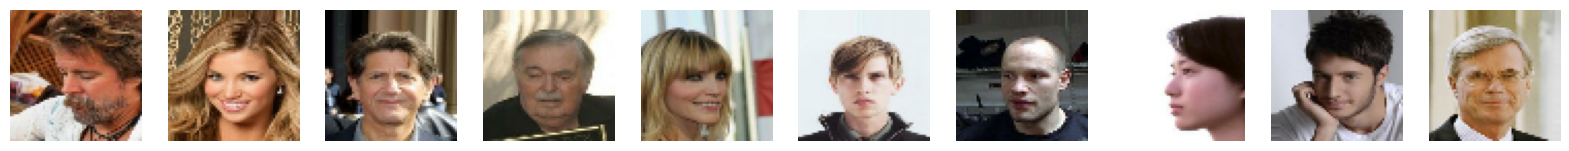

In [4]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/Users/hyunjae.k/999_Data/celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img
train = train_data.map(lambda x: preprocess(x))

train_sample = sample_batch(train)

# Show some items of clothing from the training set
plt.figure(figsize=(20, 3))
for i in range(10):
    _ = plt.subplot(1, 10, i + 1)
    plt.imshow(train_sample[i], cmap="gray")
    plt.axis("off")
plt.show()

## 3. Build Autoencoder Netwrok

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
# print(shape_before_flattening)
# print(np.prod(shape_before_flattening))

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['batch_normalization[0]

In [6]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 64)          36928     
 anspose)                                                    

In [7]:
# VAE
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [8]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 4.Train the AutoEncoder Model

In [9]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./temp/checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./temp/logs")

Path("./temp/output").mkdir(parents=True, exist_ok=True)
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./temp/output/generated_img_%03d_%d.png" % (epoch, i))

# 필요한 경우 이전 가중치 로드
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

# Save the final models
vae.save("./temp/models/vae")
encoder.save("./temp/models/encoder")
decoder.save("./temp/models/decoder")

Epoch 1/30


2025-05-06 15:02:33.884317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-06 15:02:34.130204: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1583/1583 [==============================] - ETA: 0s - loss: 77.0141 - reconstruction_loss: 51.9802 - kl_loss: 2.5764WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 66s 40ms/step - loss: 77.0000 - reconstruction_loss: 51.9802 - kl_loss: 2.5764
Epoch 2/30
1583/1583 [==============================] - ETA: 0s - loss: 40.7677 - reconstruction_loss: 37.6994 - kl_loss: 1.1185WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 63s 39ms/step - loss: 40.7664 - reconstruction_loss: 37.6994 - kl_loss: 1.1185
Epoch 3/30
1583/1583 [==============================] - ETA: 0s - loss: 34.2831 - reconstruction_loss: 32.5332 - kl_loss: 0.9508WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 66s 41ms/step - loss: 34.2826 - reconstruction_loss: 32.5332 - kl_loss: 0.9508
Epoch 4/30
1582/1583 [============================>.] - ETA: 0s - loss: 31.6969 - reconstruction_loss: 30.3855 - kl_loss: 0.8532WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 60s 38ms/step - loss: 31.6963 - reconstruction_loss: 30.3844 - kl_loss: 0.8532
Epoch 5/30
1583/1583 [==============================] - ETA: 0s - loss: 30.1757 - reconstruction_loss: 29.1113 - kl_loss: 0.7870WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 62s 39ms/step - loss: 30.1755 - reconstruction_loss: 29.1113 - kl_loss: 0.7870
Epoch 6/30
1582/1583 [============================>.] - ETA: 0s - loss: 29.1724 - reconstruction_loss: 28.1837 - kl_loss: 0.7331WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 29.1721 - reconstruction_loss: 28.1856 - kl_loss: 0.7332
Epoch 7/30
1582/1583 [============================>.] - ETA: 0s - loss: 28.3553 - reconstruction_loss: 27.4207 - kl_loss: 0.6993WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 66s 42ms/step - loss: 28.3550 - reconstruction_loss: 27.4205 - kl_loss: 0.6994
Epoch 8/30
1583/1583 [==============================] - ETA: 0s - loss: 27.5874 - reconstruction_loss: 26.7344 - kl_loss: 0.6705WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 67s 42ms/step - loss: 27.5873 - reconstruction_loss: 26.7344 - kl_loss: 0.6705
Epoch 9/30
1582/1583 [============================>.] - ETA: 0s - loss: 26.9583 - reconstruction_loss: 26.1756 - kl_loss: 0.6400WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 67s 42ms/step - loss: 26.9581 - reconstruction_loss: 26.1754 - kl_loss: 0.6400
Epoch 10/30
1582/1583 [============================>.] - ETA: 0s - loss: 26.4242 - reconstruction_loss: 25.6449 - kl_loss: 0.6243WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 66s 41ms/step - loss: 26.4240 - reconstruction_loss: 25.6466 - kl_loss: 0.6243
Epoch 11/30
1583/1583 [==============================] - ETA: 0s - loss: 25.9142 - reconstruction_loss: 25.1639 - kl_loss: 0.6021WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 66s 42ms/step - loss: 25.9141 - reconstruction_loss: 25.1639 - kl_loss: 0.6021
Epoch 12/30
1582/1583 [============================>.] - ETA: 0s - loss: 25.4446 - reconstruction_loss: 24.7543 - kl_loss: 0.5810WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 66s 42ms/step - loss: 25.4445 - reconstruction_loss: 24.7556 - kl_loss: 0.5810
Epoch 13/30
1583/1583 [==============================] - ETA: 0s - loss: 24.9807 - reconstruction_loss: 24.3307 - kl_loss: 0.5559WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 66s 42ms/step - loss: 24.9807 - reconstruction_loss: 24.3307 - kl_loss: 0.5559
Epoch 14/30
1583/1583 [==============================] - 64s 41ms/step - loss: 25.1821 - reconstruction_loss: 24.4266 - kl_loss: 0.5675
Epoch 15/30
1583/1583 [==============================] - ETA: 0s - loss: 24.9101 - reconstruction_loss: 24.0192 - kl_loss: 0.5484WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 67s 42ms/step - loss: 24.9099 - reconstruction_loss: 24.0192 - kl_loss: 0.5484
Epoch 16/30
1583/1583 [==============================] - ETA: 0s - loss: 24.2124 - reconstruction_loss: 23.6359 - kl_loss: 0.5224WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 67s 42ms/step - loss: 24.2124 - reconstruction_loss: 23.6359 - kl_loss: 0.5224
Epoch 17/30
1583/1583 [==============================] - ETA: 0s - loss: 24.0126 - reconstruction_loss: 23.4221 - kl_loss: 0.5102WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 66s 41ms/step - loss: 24.0125 - reconstruction_loss: 23.4221 - kl_loss: 0.5102
Epoch 18/30
1583/1583 [==============================] - ETA: 0s - loss: 23.7420 - reconstruction_loss: 23.1731 - kl_loss: 0.5033WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 66s 42ms/step - loss: 23.7419 - reconstruction_loss: 23.1731 - kl_loss: 0.5033
Epoch 19/30
1582/1583 [============================>.] - ETA: 0s - loss: 23.4930 - reconstruction_loss: 22.9522 - kl_loss: 0.4961WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 67s 42ms/step - loss: 23.4929 - reconstruction_loss: 22.9515 - kl_loss: 0.4962
Epoch 20/30
1583/1583 [==============================] - ETA: 0s - loss: 23.3390 - reconstruction_loss: 22.7684 - kl_loss: 0.4874WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 23.3390 - reconstruction_loss: 22.7684 - kl_loss: 0.4874
Epoch 21/30
1583/1583 [==============================] - ETA: 0s - loss: 23.1130 - reconstruction_loss: 22.5697 - kl_loss: 0.4802WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 23.1130 - reconstruction_loss: 22.5697 - kl_loss: 0.4802
Epoch 22/30
1582/1583 [============================>.] - ETA: 0s - loss: 22.9650 - reconstruction_loss: 22.4196 - kl_loss: 0.4766WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 66s 41ms/step - loss: 22.9649 - reconstruction_loss: 22.4213 - kl_loss: 0.4766
Epoch 23/30
1583/1583 [==============================] - ETA: 0s - loss: 22.7732 - reconstruction_loss: 22.2435 - kl_loss: 0.4678WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 22.7731 - reconstruction_loss: 22.2435 - kl_loss: 0.4678
Epoch 24/30
1583/1583 [==============================] - ETA: 0s - loss: 22.6186 - reconstruction_loss: 22.0793 - kl_loss: 0.4632WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 64s 41ms/step - loss: 22.6186 - reconstruction_loss: 22.0793 - kl_loss: 0.4632
Epoch 25/30
1582/1583 [============================>.] - ETA: 0s - loss: 22.4140 - reconstruction_loss: 21.8957 - kl_loss: 0.4555WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 22.4139 - reconstruction_loss: 21.8973 - kl_loss: 0.4555
Epoch 26/30
1583/1583 [==============================] - ETA: 0s - loss: 22.2635 - reconstruction_loss: 21.7679 - kl_loss: 0.4521WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 22.2635 - reconstruction_loss: 21.7679 - kl_loss: 0.4521
Epoch 27/30
1583/1583 [==============================] - ETA: 0s - loss: 22.1034 - reconstruction_loss: 21.6208 - kl_loss: 0.4457WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 22.1034 - reconstruction_loss: 21.6208 - kl_loss: 0.4457
Epoch 28/30
1582/1583 [============================>.] - ETA: 0s - loss: 21.9611 - reconstruction_loss: 21.4898 - kl_loss: 0.4401WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 21.9611 - reconstruction_loss: 21.4908 - kl_loss: 0.4401
Epoch 29/30
1582/1583 [============================>.] - ETA: 0s - loss: 21.8395 - reconstruction_loss: 21.3715 - kl_loss: 0.4370WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 63s 40ms/step - loss: 21.8394 - reconstruction_loss: 21.3721 - kl_loss: 0.4370
Epoch 30/30
1583/1583 [==============================] - ETA: 0s - loss: 21.7606 - reconstruction_loss: 21.2574 - kl_loss: 0.4347WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


1583/1583 [==============================] - 64s 41ms/step - loss: 21.7605 - reconstruction_loss: 21.2574 - kl_loss: 0.4347


INFO:tensorflow:Assets written to: ./temp/models/vae/assets


INFO:tensorflow:Assets written to: ./temp/models/vae/assets


INFO:tensorflow:Assets written to: ./temp/models/encoder/assets


INFO:tensorflow:Assets written to: ./temp/models/encoder/assets


INFO:tensorflow:Assets written to: ./temp/models/decoder/assets


INFO:tensorflow:Assets written to: ./temp/models/decoder/assets


## 5. Test

4/4 [==============================] - 0s 10ms/step


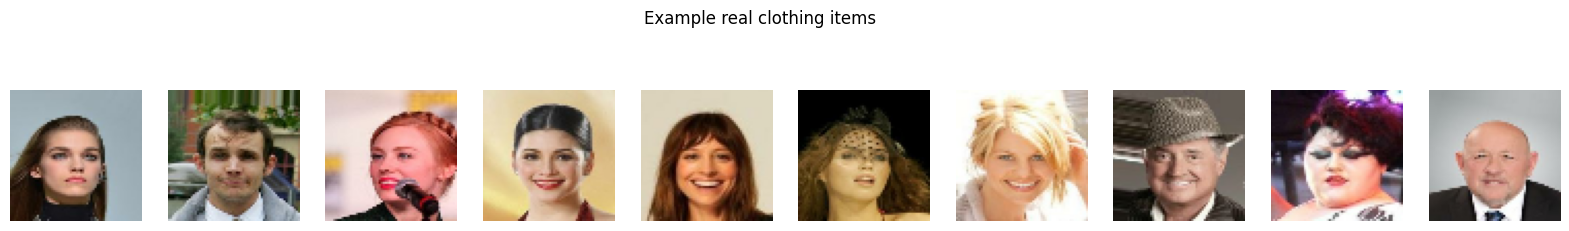

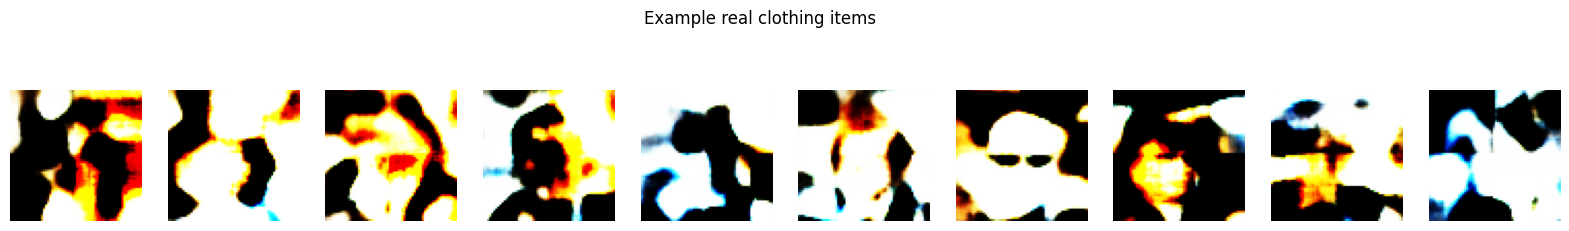

In [10]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)



# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)

plt.figure(figsize=(20, 3))
for i in range(10):
    _ = plt.subplot(1, 10, i + 1)
    plt.imshow(example_images[i], cmap="gray")
    plt.axis("off")
plt.suptitle("Example real clothing items")
plt.show()

plt.figure(figsize=(20, 3))
for i in range(10):
    _ = plt.subplot(1, 10, i + 1)
    plt.imshow(reconstructions[i], cmap="gray")
    plt.axis("off")
plt.suptitle("Example real clothing items")
plt.show()

## 6. Latent space distribution

4/4 [==============================] - 0s 3ms/step


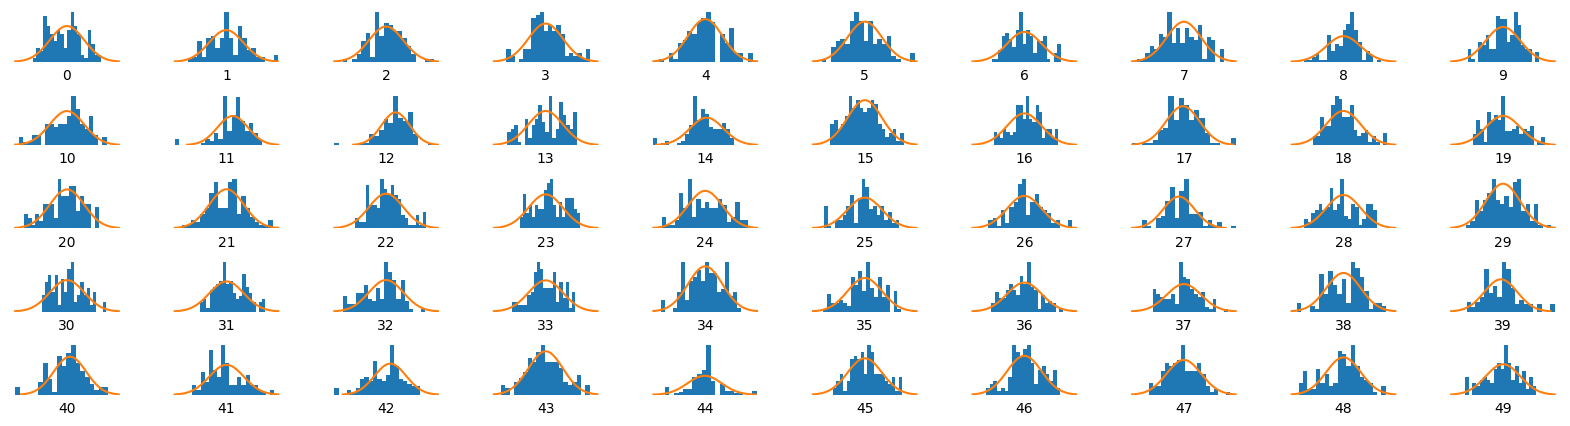

In [11]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 7. Generate new faces

1/1 [==============================] - 0s 162ms/step


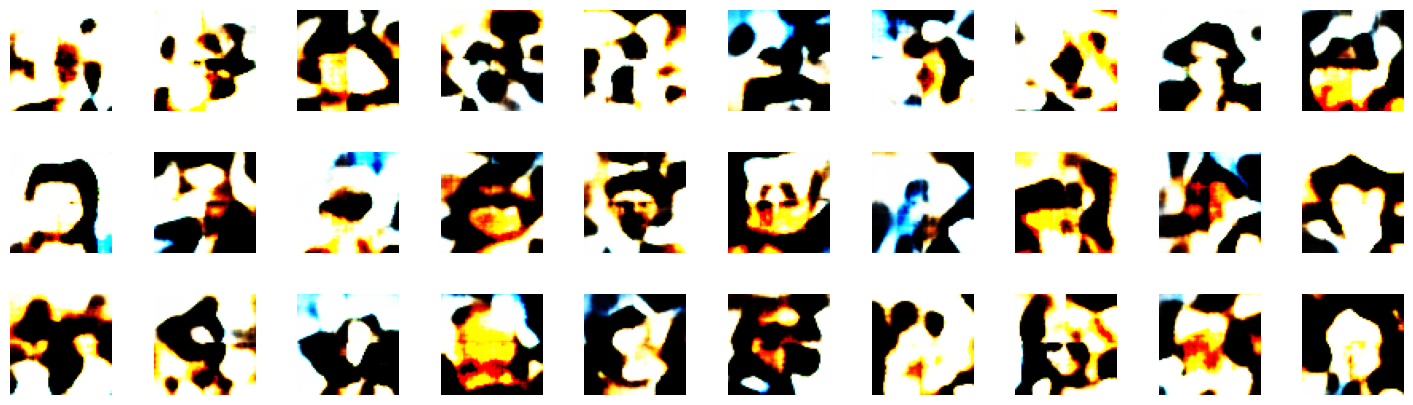

In [12]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

# Decode the sampled points
reconstructions = decoder.predict(z_sample)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulate the images

In [13]:
# Load the label dataset
attributes = pd.read_csv("/Users/hyunjae.k/999_Data/celeba/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['File_name', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,File_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [14]:
# Load the face data with label attached
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    "/Users/hyunjae.k/999_Data/celeba/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [15]:
def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10000:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector

# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.653    : 2.441    : 3.381    : 3.381
44    : 2.122    : 0.443    : 2.147    : -1.233
65    : 0.903    : 0.189    : 1.906    : -0.242
87    : 0.767    : 0.159    : 2.078    : 0.172
110    : 0.563    : 0.115    : 1.873    : -0.204
128    : 0.487    : 0.103    : 1.741    : -0.132
150    : 0.438    : 0.088    : 1.484    : -0.258
171    : 0.396    : 0.08    : 1.46    : -0.024
197    : 0.305    : 0.061    : 1.365    : -0.095
218    : 0.283    : 0.059    : 1.313    : -0.052
241    : 0.275    : 0.057    : 1.226    : -0.087
260    : 0.179    : 0.038    : 1.194    : -0.032
282    : 0.2    : 0.041    : 1.247    : 0.053
302    : 0.199    : 0.041    : 1.19    : -0.057
317    : 0.145    : 0.031    : 1.152    : -0.039
337    : 0.176    : 0.035    : 1.149    : -0.003
356    : 0.178    : 0.036    : 1.103    : -0.046
377    : 0.131    : 0.026    : 1.048    : -0.055
395    : 0.161    : 0.032    : 1.032    : -0.016
415    : 0.

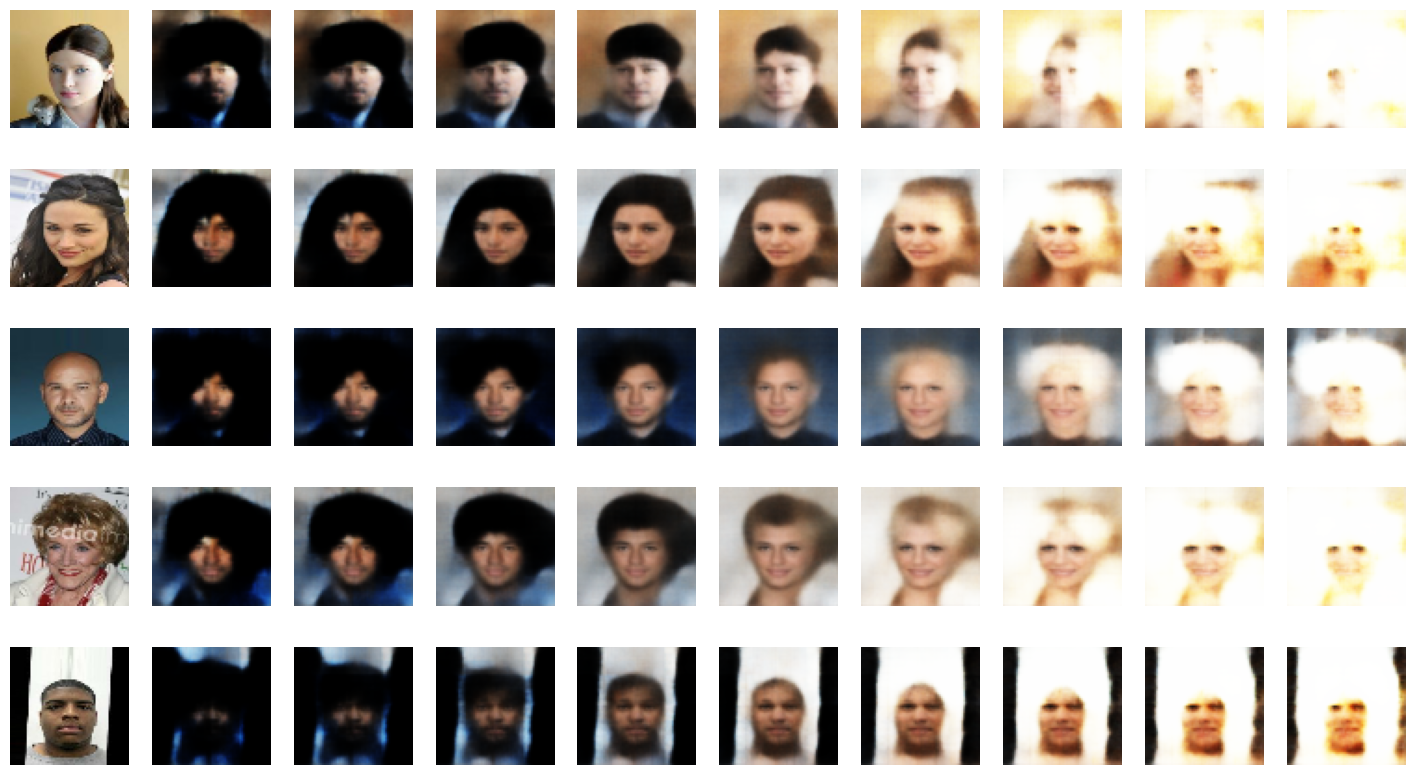

In [16]:
def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image)

            counter += 1

    plt.show()

add_vector_to_images(labelled, vae, attribute_vec)

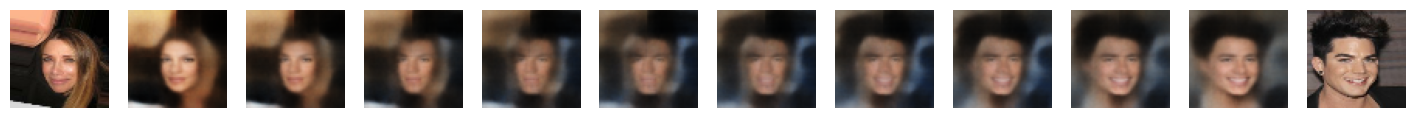

In [17]:
def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

morph_faces(labelled, vae)